<a href="https://colab.research.google.com/github/lmlima/nCov2019_analysis/blob/master/src/international_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [247]:
! git clone https://github.com/jianxu305/nCov2019_analysis/
#! git pull

!pip install bokeh
!pip install pandas-bokeh

import bokeh
import pandas_bokeh
pandas_bokeh.output_notebook()
%load_ext google.colab.data_table




fatal: destination path 'nCov2019_analysis' already exists and is not an empty directory.
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [0]:
import sys
import os
os.chdir('/content/nCov2019_analysis/src')

sys.path.append('/content/nCov2019_analysis/src')

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
import datetime

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# dxy_raw = utils.load_chinese_data()

In [0]:
# dxy_frm = utils.aggDaily(dxy_raw)

In [0]:
_JHS_DATA_PATH_ = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
_JHS_DATA_START_DATE = '2020-01-22'


In [0]:
def fix_jhs_cvs_change(df):
  changed_dict = {'Province/State': ['Province/State', 'Province_State'], 
                  'Country/Region': ['Country/Region', 'Country_Region'],
                  'Last Update': ['Last Update', 'Last_Update'] ,
                  }
  for col, opts in changed_dict.items():
    df[col] = df[opts].bfill(axis=1).iloc[:, 0]
  
  return df
          

def load_jhs_raw(verbose=False):
    dr = pd.date_range(_JHS_DATA_START_DATE, datetime.date.today())
    frm_list = []
    for date in dr:
        if verbose:
            print("Reading: " + str(date))
        try:
            frm = pd.read_csv(_JHS_DATA_PATH_ + date.strftime('%m-%d-%Y') + '.csv')
            frm_list.append(frm)
        except:
            continue
        
    out = pd.concat(frm_list, sort=False).drop_duplicates()

    out = fix_jhs_cvs_change(out)

    rename_dict = {'Province/State': 'province/state', 
                  'Country/Region': 'country/region',
                  'Confirmed': 'cum_confirmed',
                   'Deaths': 'cum_dead',
                   'Recovered': 'cum_cured'  # this is a bit inaccurate
                  }
    out = out.rename(columns=rename_dict)
    out['update_time'] = pd.to_datetime(out['Last Update'])
    out['update_date'] = out['update_time'].dt.date
    province = out['province/state']
    out['province/state'] = out['province/state'].fillna('') # replace NaN province with empty string
    out['country/region'] = out['country/region'].replace('Others', 'Diamond Princess')
    out = out.sort_values(['update_date', 'country/region', 'province/state'])
    out = out.reset_index().drop(columns='index')
    return out

In [254]:
# Fix for data after 03-22-2020
jhs_raw = load_jhs_raw(verbose=True)

Reading: 2020-01-22 00:00:00
Reading: 2020-01-23 00:00:00
Reading: 2020-01-24 00:00:00
Reading: 2020-01-25 00:00:00
Reading: 2020-01-26 00:00:00
Reading: 2020-01-27 00:00:00
Reading: 2020-01-28 00:00:00
Reading: 2020-01-29 00:00:00
Reading: 2020-01-30 00:00:00
Reading: 2020-01-31 00:00:00
Reading: 2020-02-01 00:00:00
Reading: 2020-02-02 00:00:00
Reading: 2020-02-03 00:00:00
Reading: 2020-02-04 00:00:00
Reading: 2020-02-05 00:00:00
Reading: 2020-02-06 00:00:00
Reading: 2020-02-07 00:00:00
Reading: 2020-02-08 00:00:00
Reading: 2020-02-09 00:00:00
Reading: 2020-02-10 00:00:00
Reading: 2020-02-11 00:00:00
Reading: 2020-02-12 00:00:00
Reading: 2020-02-13 00:00:00
Reading: 2020-02-14 00:00:00
Reading: 2020-02-15 00:00:00
Reading: 2020-02-16 00:00:00
Reading: 2020-02-17 00:00:00
Reading: 2020-02-18 00:00:00
Reading: 2020-02-19 00:00:00
Reading: 2020-02-20 00:00:00
Reading: 2020-02-21 00:00:00
Reading: 2020-02-22 00:00:00
Reading: 2020-02-23 00:00:00
Reading: 2020-02-24 00:00:00
Reading: 2020-

In [0]:
# Not work after 03-22-2020
# jhs_raw = utils.load_jhs_raw()

In [0]:
jhs_frm = utils.jhs_daily(jhs_raw)

In [257]:
jhs_frm.sort_values(by='Last Update', ascending=False).head()

,province/state,country/region,Last Update,cum_confirmed,cum_dead,cum_cured,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,update_time,update_date,new_confirmed,new_dead,new_cured
5170,Hubei,China,3/22/20 9:33,67800.0,3144.0,59433.0,NaN,NaN,NaN,NaN,Hubei,China,3/22/20 9:33,30.9756,112.2707,5223.0,"Hubei, China",2020-03-22 09:33:00,2020-03-22,0.0,5.0,487.0
5169,Hong Kong,China,3/22/20 9:33,317.0,4.0,100.0,NaN,NaN,NaN,NaN,Hong Kong,China,3/22/20 9:33,22.3000,114.2000,213.0,"Hong Kong, China",2020-03-22 09:33:00,2020-03-22,44.0,0.0,2.0
5309,,Taiwan*,3/22/20 8:11,169.0,2.0,28.0,NaN,NaN,NaN,NaN,NaN,Taiwan*,3/22/20 8:11,23.7000,121.0000,139.0,Taiwan*,2020-03-22 08:11:00,2020-03-22,16.0,0.0,0.0
5175,Shandong,China,3/22/20 8:10,766.0,7.0,750.0,NaN,NaN,NaN,NaN,Shandong,China,3/22/20 8:10,36.3427,118.1498,9.0,"Shandong, China",2020-03-22 08:10:00,2020-03-22,2.0,0.0,1.0
5168,Heilongjiang,China,3/22/20 7:20,484.0,13.0,466.0,NaN,NaN,NaN,NaN,Heilongjiang,China,3/22/20 7:20,47.8620,127.7615,5.0,"Heilongjiang, China",2020-03-22 07:20:00,2020-03-22,0.0,0.0,3.0


# Compare countries after 50 cum_confirmed

In [272]:
# most international data only has country info, so do not drill down to finer level now
country_frm = jhs_frm.groupby(['country/region', 'update_date']).agg('sum').reset_index() 
country_frm[country_frm['country/region']=='US'].tail()
# jhs_frm.head()

,country/region,update_date,cum_confirmed,cum_dead,cum_cured,Latitude,Longitude,FIPS,Lat,Long_,Active,new_confirmed,new_dead,new_cured
4521,US,2020-03-31,2271.0,51.0,7024.0,0.0,0.0,1628881.0,1928.148070,-4152.731648,0.0,296.0,13.0,1380.0
4522,US,2020-04-01,2735.0,62.0,8474.0,0.0,0.0,1638888.0,1966.353630,-4230.028038,0.0,464.0,11.0,1450.0
4523,US,2020-04-02,3018.0,71.0,9001.0,0.0,0.0,1867124.0,1883.430636,-4049.196931,0.0,283.0,9.0,527.0
4524,US,2020-04-03,3431.0,82.0,9707.0,0.0,0.0,1779414.0,1948.624261,-4201.804761,0.0,413.0,11.0,706.0
4525,US,2020-04-04,3996.0,102.0,14652.0,0.0,0.0,1779414.0,1948.624261,-4201.804761,0.0,565.0,20.0,4945.0


In [0]:
countries=['Mainland China', 'Japan', 'South Korea', 'US','Brazil','Italy', 'Ecuador', 'France', 'Spain']
jhs_50=country_frm[(country_frm['country/region'].isin(countries)) & (country_frm['cum_confirmed']>50)].copy()

In [0]:
countries_50 = []
for country in countries:
  c_df=jhs_50[(jhs_50['country/region']==country)].sort_values('update_date').reset_index()[['cum_confirmed', 'new_confirmed', 'cum_dead', 'new_dead', 'country/region']].copy()
  countries_50.append(c_df)
# brazil["pais"]='Brazil'
# italy=jhs_50[(jhs_50['country/region']=='Italy')].sort_values('update_date').reset_index()[['cum_confirmed','country/region']].copy()
# italy["pais"]='Italy'


In [0]:
# # US
# jhs_50_us=jhs_frm[(jhs_frm['country/region'].isin(["US"])) & (jhs_frm['cum_confirmed']>50)].copy()
# jhs_50_us_agg = jhs_50_us.groupby("update_date").agg({'cum_confirmed': 'sum', 'new_confirmed': sum, 'cum_dead': 'sum', 'new_dead': sum, 'country/region':'last'})

# c_df=jhs_50_us_agg[(jhs_50_us_agg['country/region']=="US")].sort_values('update_date').reset_index()[['cum_confirmed', 'new_confirmed', 'cum_dead', 'new_dead', 'country/region']].copy()

# countries_50.append(c_df)


In [0]:
# countries_50

In [262]:
df=pd.concat(countries_50).reset_index().copy()
df["log_cum_confirmed"]=np.log(df['cum_confirmed'])
df["log_cum_dead"]=np.log(df['cum_dead'])

# df


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



##New


### Confirmed

In [263]:
df_cum = df.pivot(index='index', columns='country/region', values='new_confirmed')

# df.plot()
df_cum.plot_bokeh(rangetool=True)

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_fiel

Column(id='21492', ...)

###Dead

In [264]:
df_cum = df.pivot(index='index', columns='country/region', values='new_dead')

# df.plot()
df_cum.plot_bokeh(rangetool=True)

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_fiel

Column(id='22111', ...)

##Cumulative

###Confirmed

In [265]:
df_cum = df.pivot(index='index', columns='country/region', values='cum_confirmed')

# df.plot()
df_cum.plot_bokeh(rangetool=True)

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_fiel

Column(id='22773', ...)

### Log Confirmed

In [266]:
df_log = df.pivot(index='index', columns='country/region', values='log_cum_confirmed')

# df.plot()
df_log.plot_bokeh(rangetool=True)

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_fiel

Column(id='23478', ...)

### Dead

In [267]:
df_cum = df.pivot(index='index', columns='country/region', values='cum_dead')

# df.plot()
df_cum.plot_bokeh(rangetool=True)

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_fiel

Column(id='24226', ...)

### Log Dead

In [268]:
df_log = df.pivot(index='index', columns='country/region', values='log_cum_dead')

# df.plot()
df_log.plot_bokeh(rangetool=True)

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

/usr/local/lib/python3.6/dist-packages/bokeh/util/deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_fiel

Column(id='25017', ...)

## 1. Sanity Check
### 1.1 Take a Brief Look at the data

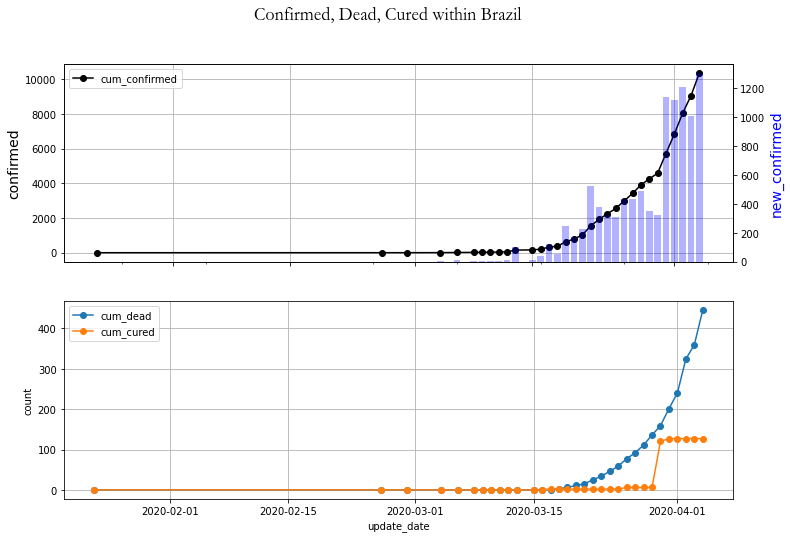

In [212]:
fig = utils.tsplot_conf_dead_cured(jhs_frm[jhs_frm['country/region'] == 'Brazil'], 
                                   title='Confirmed, Dead, Cured within Brazil', figsize=(12, 8))

## 2. Mortality Rate vs Confirmed Count

In [191]:
!pip install chart_studio

In [0]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio

In [0]:
api_key  = ''  # use you own key
user_name = ''  # use your own user name
chart_studio.tools.set_credentials_file(username=user_name, api_key=api_key)

In [0]:
# most international data only has country info, so do not drill down to finer level now
country_frm = jhs_frm.groupby(['country/region', 'update_date']).agg('sum')  

### Remove Some Data Problem
Japan and US has some dates with negative new_confirm

In [195]:
country_frm[country_frm['new_confirmed'] < 0]

,,cum_confirmed,cum_dead,cum_cured,Latitude,Longitude,FIPS,Lat,Long_,Active,new_confirmed,new_dead,new_cured
country/region,update_date,,,,,,,,,,,,
Albania,2020-03-12,23.0,1.0,0.0,41.1533,20.1683,0.0,0.000000,0.000000,0.0,-10.0,0.0,0.0
Algeria,2020-03-12,24.0,1.0,8.0,28.0339,1.6596,0.0,0.000000,0.000000,0.0,-2.0,-1.0,0.0
Armenia,2020-03-12,4.0,0.0,0.0,40.0691,45.0382,0.0,0.000000,0.000000,0.0,-4.0,0.0,0.0
Azerbaijan,2020-03-16,15.0,1.0,6.0,40.1431,47.5769,0.0,0.000000,0.000000,0.0,-8.0,0.0,0.0
Belarus,2020-03-12,12.0,0.0,3.0,53.7098,27.9534,0.0,0.000000,0.000000,0.0,-15.0,0.0,0.0
Canada,2020-03-12,97.0,1.0,8.0,157.9204,-286.5199,0.0,0.000000,0.000000,0.0,-49.0,0.0,0.0
Costa Rica,2020-03-12,22.0,0.0,0.0,9.7489,-83.7534,0.0,0.000000,0.000000,0.0,-1.0,0.0,0.0
Cuba,2020-03-12,3.0,0.0,0.0,22.0000,-80.0000,0.0,0.000000,0.000000,0.0,-1.0,0.0,0.0
Diamond Princess,2020-03-06,696.0,6.0,40.0,35.4437,139.6380,0.0,0.000000,0.000000,0.0,-10.0,0.0,30.0


In [0]:
country_frm['new_confirmed'] = np.maximum(0, country_frm['new_confirmed'])   # Japan 1/23, 2/7, US 2/24 have new confirmed < 0, looks like data error

### Add Mortality Rate, Moving Average, etc

In [197]:
country_frm['mortality_rate'] = country_frm['cum_dead'] / country_frm['cum_confirmed']
country_frm = utils.add_moving_average(country_frm, ['country/region'], win_size=3)

/content/nCov2019_analysis/src/utils.py:332: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [0]:
# The following columns are mainly for plot rendering
country_frm['new_confirmed_logMA'] = np.log10(country_frm['new_confirmed_MA'] + 2)
color_countries = ['Mainland China', 'Japan', 'South Korea', 'Iran', 'Italy', 'Germany', 
                   'US', 'France', 'Spain', 'Diamond Princess', 'Thailandl', 'Taiwan', 'Hong Kong',
                   'Singapore', 'UK', 'Iraq', 'Brazil', 'Colombia', 'Peru', 'Ecuador']
country_frm['color'] = np.where(country_frm.index.get_level_values('country/region').isin(color_countries), 
                                country_frm.index.get_level_values('country/region'), 
                                'Other')
country_ex_china = country_frm[country_frm.index.get_level_values('country/region') != 'Mainland China']

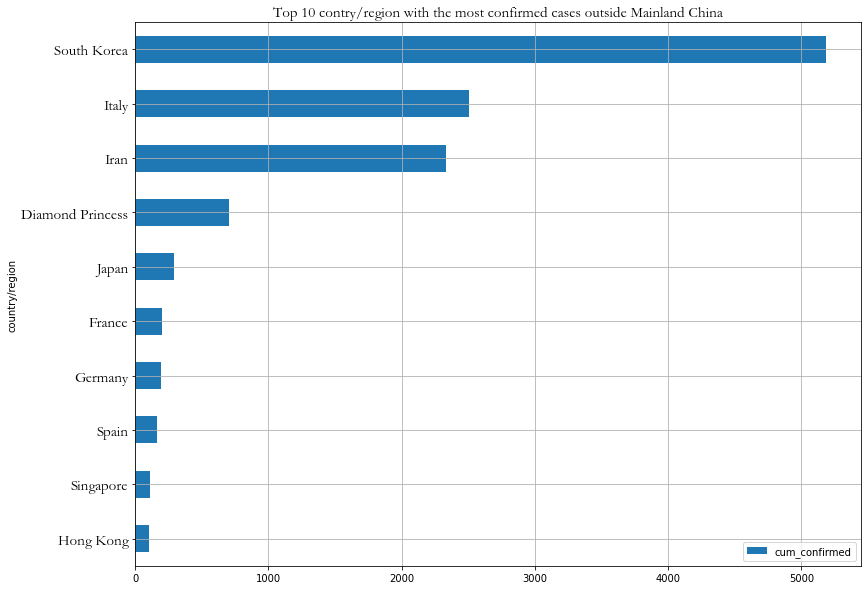

In [210]:
fig = utils.cross_sectional_bar(country_ex_china.reset_index(), '2020-03-03', 'cum_confirmed', 'country/region', 10,
                                title='Top 10 contry/region with the most confirmed cases outside Mainland China')

#### Flashback to 2020-04-04

In [211]:
date = datetime.date(2020, 4, 4)
frm = country_ex_china.loc[(slice(None), date), :].reset_index()
# frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 color='color',
                 text='country/region',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['country/region', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.01, 0.15], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.01, 0.15], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[4, 2000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[4, 2000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()

In [0]:
pio.write_html(fig, file='index.html', auto_open=True)

In [0]:
# country_ex_china.loc[]

### 2020-03-02

In [203]:
date = datetime.date(2020, 3, 22)
frm = country_ex_china.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 color='color',
                 text='country/region',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['country/region', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
fig.update_traces(textposition='top center')
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.01, 0.08], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.01, 0.08], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[20, 5000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[20, 5000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.show()

### Comparison: China has been stable in the past two weeks

In [204]:
china_frm = dxy_frm.copy()
china_frm['province_name'] = np.where(china_frm['city_name'] == '武汉', '武汉', china_frm['province_name'])  # treat Wuhan as a province
china_frm['province_name'] = np.where(china_frm['province_name'] == '湖北省', '湖北省除武汉', china_frm['province_name'])
china_province = china_frm.groupby(['province_name', 'update_date']).agg('sum')

NameError: ignored

In [0]:
china_province = utils.add_moving_average(china_province, ['province_name'], 3)
china_province['mortality_rate'] = china_province['cum_dead'] / china_province['cum_confirmed']
china_province['new_confirmed_logMA'] = np.log10(china_province['new_confirmed_MA'] + 2)

In [0]:
date = datetime.date(2020, 2, 19)
frm = china_province.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
#frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 #color='color',
                 text='province_name',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[15, 50000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[15, 50000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()

### China on 2020-03-02, bubbles are diminishing, so spread is slowed down

In [0]:
date = datetime.date(2020, 3, 2)
frm = china_province.loc[(slice(None), date), :].reset_index()
#frm = frm[frm['cum_confirmed'] >= 5]  # only show countries with more than 5 confirmed cases
#frm = frm[frm['color'] != 'Other']
fig = px.scatter(frm,
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 size_max=frm['new_confirmed_logMA'].max() * 8,
                 #color='color',
                 text='province_name',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
# add lines to split the region
fig.add_trace(go.Scatter(x=[100, 100], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[500, 500], y=[-0.005, 0.05], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[50, 50000], y=[0.02, 0.02], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.add_trace(go.Scatter(x=[50, 50000], y=[0.01, 0.01], mode="lines", line={'dash': 'dot', 'color': 'orange'}))
fig.update_traces(textposition='top center')

fig.show()